# Phase 1 - 구조적 정확도 개선 (Target 95%)

## 개요

### Base vs Phase 1 비교

| 구분 | Base (75%) | Phase 1 (95%) |
|-----|-----------|---------------|
| **스키마 전달 방식** | 80개 테이블 전체를 프롬프트에 포함 | 질문과 관련된 테이블만 선택적으로 전달 |
| **시간 표현 처리** | ❌ LLM이 연도를 임의로 가정 | ✅ 오늘 날짜 제공 + 모호하면 사용자에게 확인 |
| **모호한 질문 처리** | ❌ LLM이 임의로 해석 | ✅ 명확화 질문으로 사용자 의도 확인 |
| **SQL 검증** | ❌ 없음 | ✅ 실행 전 문법 오류 검사 |
| **오류 복구** | ❌ 실패하면 그대로 종료 | ✅ 오류 발생 시 자동 재시도 |
| **대규모 스키마** | ❌ 전체 스키마 주입 (토큰 낭비) | ✅ 스키마 검색으로 관련 테이블만 선별 |
| **업무 용어** | ❌ LLM이 추측 | ✅ 용어 사전으로 정확한 조건 매핑 |
| **결과 검증** | ❌ 없음 | ✅ 빈 결과, 비정상 값 자동 감지 |


---

### Phase 1 시스템 흐름

```
[Base]
사용자 질문 → (80개 스키마 전체 전달) → SQL 생성 → 실행 → 응답

[Phase 1]  
사용자 질문
    → 스키마 검색 (관련 테이블만 선별)
    → 용어 사전 조회 (사내 용어 → DB 조건 변환)
    → 모호한 부분 감지 ─────────────────┐
    → 사용자에게 확인 질문 (필요시)      │ 명확해질 때까지 반복
    ← 사용자 답변 ←─────────────────────┘
    → SQL 생성 (오늘 날짜 포함)
    → SQL 문법 검사
    → 실행
    → 결과 검증 ───────────────────────┐
    → (빈 결과/오류 시 자동 수정)        │ 최대 3회
    ←──────────────────────────────────┘
    → 결과 응답
```

---

### Phase 1 구현 항목

#### 본 문서에서 구현 (PoC)

| 기능 | 상태 | 해결하는 문제 |
|-----|-----|-------------|
| 오늘 날짜 주입 | ✅ 구현 | "상반기" 등 시간 표현 오해석 |
| 모호성 감지 | ✅ 구현 | "금액이 높은" 등 모호한 용어 |
| 사용자 확인 질문 | ✅ 구현 | LLM 임의 해석 방지 |
| SQL 문법 검사 | ✅ 구현 | 존재하지 않는 컬럼 사용 |
| 오류 시 자동 재시도 | ✅ 구현 | 일시적 오류 복구 |
| 선택적 스키마 전달 | ✅ 구현 | 토큰 비용 절감 |

#### Enterprise 환경 추가 구현 필요

| 기능 | 설명 | 해결하는 문제 |
|-----|------|-------------|
| **스키마 검색** | 질문과 유사한 테이블/컬럼 자동 검색 | 80개 테이블에서 관련 테이블 선별 |
| **용어 사전** | 사내 용어 → DB 조건 매핑 | "미입력자" = `actual_mm < 1` |
| **결과 검증** | 빈 결과, 비정상 값 자동 감지 | 조용한 실패 방지 |

---

### Enterprise 추가 구현 상세

#### 1. 스키마 검색 (Schema Retrieval)

80개 테이블을 모두 전달하면 토큰 낭비, 안 전달하면 관련 테이블 누락

```
[현재] 사용자 질문 → LLM이 테이블명만 보고 추측
[개선] 사용자 질문 → 테이블/컬럼 설명과 유사도 비교 → 관련 스키마만 전달
```

- 각 테이블/컬럼에 대한 설명을 미리 저장
- 사용자 질문과 가장 관련 높은 테이블 5~10개만 자동 선별
- 예: "인건비" 질문 → `project_cost`, `employee_salary` 테이블 자동 추천

#### 2. 용어 사전 (Knowledge Graph)

"미입력자", "활성 프로젝트" 등 사내에서만 통용되는 용어를 LLM이 모름

```
[현재] "미입력자" → LLM이 NULL로 추측 → 오답
[개선] "미입력자" → 용어 사전 조회 → actual_mm < 1 적용 → 정답
```

| 사내 용어 | 실제 의미 (DB 조건) |
|----------|-------------------|
| 미입력자 | `actual_mm < 1` |
| 활성 프로젝트 | `status = 'IN_PROGRESS'` |
| 전직원 | `resignation_date IS NULL` |
| 상반기 | `month BETWEEN 1 AND 6` |

#### 3. 결과 검증 (Self-Correction)

SQL은 실행됐지만 결과가 비어있거나 비상식적인 값일 때 감지 못함

```
[현재] 결과 0건 → 그대로 "결과 없음" 응답
[개선] 결과 0건 → 조건 확인 → 날짜 범위 확장 → 재시도 → 결과 반환
```

- 결과가 0건이면 자동으로 조건 완화 후 재시도
- 결과 값이 비정상적이면 (예: 음수 금액이 최대값) 경고

## Phase1 예시 코드 구현

In [1]:
from langchain.chat_models import init_chat_model
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.messages import (
    AnyMessage,
    HumanMessage,
    SystemMessage,
    AIMessage,
)

from langgraph.graph import StateGraph, END, START, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command, interrupt

from rich import print as rprint
from sqlalchemy import create_engine
from IPython.display import display, Image
from pydantic import BaseModel, Field
from typing import Literal, Optional
from datetime import date

import pandas as pd
import uuid

### Initialize Database

In [2]:
def setup_database(db_path: str = "sqlite:///data/mydb.db") -> SQLDatabase:
    """Initialize SQL database connection."""
    engine = create_engine(db_path)
    db = SQLDatabase(engine)
    return db

# Global instances
db = setup_database()

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")

Dialect: sqlite
Available tables: ['cards', 'customers', 'merchant_category', 'transactions']


### State

In [3]:
class SQLAgentState(MessagesState):
  original_question: Optional[str]          # 원본 질문
  clarified_question: Optional[str]         # 명확화된 질문  
  ambiguities: Optional[list[dict]]         # 감지된 애매모호성 목록
  evidence: Optional[str]                   # 축적된 명확화 컨텍스트 (QA pairs)
  is_clarified: bool                        # 명확화 완료 여부
  schema_info: Optional[str]                # 가져온 스키마 정보
  clarification_count: int = 0              # 명확화 시도 횟수

class AmbiguityItem(BaseModel):
    question: str = Field(description="명확화 질문")
    level_1_label: str = Field(description="DB-related ambiguity | LLM-related ambiguity")
    level_2_label: str = Field(description="구체적인 모호성 유형")
    choices: list[str] = Field(description="사용자 선택지 목록")

class AmbiguityDetectionResult(BaseModel):
    has_ambiguity: bool = Field(description="모호성 존재 여부")
    question_set: list[AmbiguityItem] = Field(default=[], description="모호성 목록")

### Initialize Model

In [4]:
def setup_llm(model: str = "gpt-4.1-mini", temperature: float = 0):
    """Initialize LLM for the agent."""
    llm = init_chat_model(
        model=model, model_provider="openai", temperature=temperature
    )
    return llm

# Global instances
llm = setup_llm()

### Prompt

In [5]:
GENERATE_QUERY_SYSTEM_PROMPT = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Current date: {current_date}
"""

CHECK_QUERY_SYSTEM_PROMPT = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
"""

# AmbiSQL 참조
AMBIGUITY_DETECTION_PROMPT = """
## Task
Given a user's question(or statement), database schema, and optional evidence, identify any ambiguities and generate clarifying questions to resolve them.

## Definitions:
- A user question is identifies as ambiguous when there is more than one reasonable interpretation due to unclear, incomplete, or conflicting information.
- Level 1:
    - "DB-related ambiguity": Ambiguity that leads to incorrect or incomplete data retrieval directly from the database, due to unclear or underspecified aspects of the user query with respect to the database schema or content.
    - "LLM-related ambiguity": Ambiguity that results in the misuse of LLM external knowledge, causing difficulties in correctly retrieving or applying information beyond the database.
- Level 2 examples:
    - DB-related:
        - "Unclear schema reference": The question lacks sufficient context to determine which table or column to use for operations like filtering, ranking, or aggregation, resulting in multiple plausible interpretations (e.g., "the oldest user" could refer to 'age' column or 'registration_date' column).
        - "Unclear value reference": The question refers to a value that does not correctly correspond to the actual values stored in the database, making it unclear how to formulate the WHERE clause condition and potentially causing relevant results to be omitted or producing inaccurate results.
          - (e.g., querying posts mentioning the "R programming language" without clarifying whether to match exact phrases or variations).
          - (e.g., querying for "New York City" when the database stores "NYC" or asking for posts about "COVID-19" when the database contains "coronavirus")
        - "Missing SQL-related keywords": Key terms clarifying the intended operation are absent, leading to ambiguity about the desired SQL operation (e.g., query for top 5 popular tags's star, which can list each tag's star or the amount stars).
    - LLM-related:
        - "Unclear knowledge source": The question fails to specify whether required information should be retrieved from the database or inferred through LLM reasoning (e.g., for "female employees," whether to query a gender column or use semantic analysis of name fields).
        - "Insufficient reasoning context": The question lacks adequate information to guide LLM reasoning effectively (e.g., requesting dynamic or time-sensitive external information like "current exchange rate" without specifying the target currencies or date).
        - "Conflicting knowledge": Knowledge assumptions embedded within the question contradicts real-world facts or database contents (e.g., querying entities or participants in events that never occurred).
        - "Ambiguous temporal/spatial scope": Spatial or temporal constraints are underspecified, resulting in multiple possible interpretations at different granularities 
          - (e.g., "after the 2018 World Cup" could mean immediately after the final match or after the entire tournament year).
          - (e.g., missing countries in the list for "Middle East" due to vague or imprecise geographic constraints).

## Instructions:
1. Identify all ambiguous phrases in the question (using schema and evidence if provided).
2. For each unresolved ambiguity, write a clarifying (yes/no, binary, or multiple-choice) question for user to further clarify their intent.
3. For each, assign exactly one Level 1 and one Level 2 label.
4. For each, provide a brief user-facing description. Formulate the descroption of each ambiguity as follows:
  i. For "Unclear schema reference", list all plausible columns with relevant schema info retrieved from the input database schema.
  ii. For "Ambiguous temporal/spatial scope", include all possible answers in complete in description for user to select(Do not use such as or etc to omit some options).
  iii. For "Unclear value reference", "Missing SQL-related keywords", "Unclear knowledge source", "Insufficient reasoning context" or "Conflicting knowledge", List some possible interpretations as choices(more then 2).
5. **Important Note**: Not each input question is ambiguous. If no ambiguities remain, return an empty question_set. (e.g., If only one column in the database is plausible, it should not be an unclear schema reference)
6. **Temporal ambiguity check**: If the question mentions relative time periods (e.g., "상반기", "last year", "this month", "recent") without specifying the exact year, flag it as "Ambiguous temporal/spatial scope" and ask which year the user means.

Input:
Question: {question}
Schema: {schema}
Evidence: {evidence}
Current date: {current_date}
"""

QUESTION_REFINE_PROMPT = '''
# Task
To combine an `original_question` with `additional_information` into a single, coherent, and complete new question that is logically sound and easy to understand.

# Core Principles
1.  **Absolute Preservation**: You MUST preserve ALL constraints, details, and intents from the `original_question`. Nothing from the original should be omitted or altered unless it is directly and explicitly contradicted by the `additional_information`.
2.  **Full Integration**: You MUST seamlessly integrate ALL new requirements and constraints from the `additional_information` into the new question.
3.  **Conflict Resolution**: If a piece of `additional_information` directly conflicts with a part of the `original_question`, the `additional_information` takes precedence and should be used to update or replace the conflicting part. This is the **only** scenario where original information may be modified.
4.  **Natural Language**: The final output must be a single, natural-sounding question, not a list of criteria.

# Examples
Original question: List all novels published after 2000 that won a Booker Prize.
Additional information: Only include novels that were also adapted into movies and written by female authors.
Rewritten question: List all novels published after 2000 that won a Booker Prize, were adapted into movies, and were written by female authors.

Original question: Which Asian countries have a GDP per capita above $30,000 and a population under 10 million?
Additional information: Exclude countries that are island nations.
Rewritten question: Which Asian countries that are not island nations have a GDP per capita above $30,000 and a population under 10 million?

Original question: Provide the list of Olympic gold medalists in swimming events for the last three Summer Olympics, including their ages at the time of winning.
Additional information: I am only interested in male athletes from North America, and only in individual events.
Rewritten question: Provide the list of male North American Olympic gold medalists in individual swimming events for the last three Summer Olympics, including their ages at the time of winning.

# Response Format
- Return **only** the text of the rewritten question.
- Do not include any preamble, labels (like "Rewritten question:"), or explanations.

---

Original question: {question}

Additional information: {additional_info}

Rewritten question:
'''

### Nodes & Tools

In [6]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

run_query_tool = next(tool for tool in tools if tool.name=="sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query_tool")

get_schema_tool = next(tool for tool in tools if tool.name=="sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema_tool")

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

In [7]:
# predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": str(uuid.uuid4()),
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    # 테이블 이름 가져오기
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}

# force a model to create a tool call
def call_get_schema(state: SQLAgentState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}

def generate_query(state: SQLAgentState):

    prompt = GENERATE_QUERY_SYSTEM_PROMPT.format(
        dialect=db.dialect,
        top_k=5,
        current_date=str(date.today()),  # 날짜 추가
    )

    system_message = {
        "role": "system",
        "content": prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}

def check_query(state: MessagesState):
    prompt = CHECK_QUERY_SYSTEM_PROMPT.format(dialect=db.dialect)

    system_message = {
        "role": "system",
        "content": prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

def detect_ambiguity(state: SQLAgentState):
    
    question = state.get("clarified_question") or state["original_question"]
    schema = state.get("schema_info", "")
    evidence = state.get("evidence")
    prompt = AMBIGUITY_DETECTION_PROMPT.format(
        question=question,
        schema=schema,
        evidence=evidence if evidence else "None",
        current_date=str(date.today())
    )
    structured_llm = llm.with_structured_output(AmbiguityDetectionResult)
    result = structured_llm.invoke(prompt)

    return {
        "ambiguities": result.question_set,  # list[AmbiguityItem]
        "is_clarified": not result.has_ambiguity
    }


def handle_clarification(state: SQLAgentState):
    """
    명확화 요청 + 질문 재작성을 하나의 노드로 통합.
    interrupt()로 사용자 답변을 받고, 바로 질문을 재작성함.
    """
    ambiguities = state["ambiguities"]
    if not ambiguities:
        return {}
    
    ambiguity = ambiguities[0]

    # interrupt로 사용자 답변 대기
    user_answer = interrupt({
        "question": ambiguity.question,
        "choices": ambiguity.choices,
        "level_1": ambiguity.level_1_label,
        "level_2": ambiguity.level_2_label
    })

    # --- resume 후 이 아래 코드가 실행됨 ---
    
    original = state["original_question"]
    current_evidence = state.get("evidence", "") or ""

    # Evidence 축적
    new_evidence = f"{current_evidence}\nQ: {ambiguity.question}\nA: {user_answer}"

    # 질문 재작성
    refined = llm.invoke(
        QUESTION_REFINE_PROMPT.format(
            question=state.get("clarified_question") or original,
            additional_info=user_answer
        )
    )

    # 남은 모호성 제거 (처리된 것)
    remaining = ambiguities[1:] if len(ambiguities) > 1 else []

    return {
        "clarified_question": refined.content,
        "evidence": new_evidence,
        "ambiguities": remaining,
        "clarification_count": state.get("clarification_count", 0) + 1
    }


### Build LangGraph

In [8]:
def should_clarify(state: SQLAgentState) -> Literal["handle_clarification", "generate_query"]:
    if state.get("ambiguities") and not state.get("is_clarified"):
        return "handle_clarification"
    return "generate_query"

def after_clarification(state: SQLAgentState) -> Literal["detect_ambiguity", "generate_query"]:
    # 추가 모호성 체크 또는 바로 SQL 생성
    if state.get("clarification_count", 0) < 3:  # 최대 3회
        return "detect_ambiguity"
    return "generate_query"

def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"

def create_sql_agent_graph():
    """
    Create the LangGraph workflow for SQL agent.
    
    Workflow:
        START → list_tables → get_schema → detect_ambiguity 
              → (clarification loop) → generate_query → check → run → answer
    """

    # Create graph
    builder = StateGraph(SQLAgentState)

    # Add nodes
    builder.add_node("list_tables", list_tables)
    builder.add_node("call_get_schema", call_get_schema)
    builder.add_node("get_schema", get_schema_node)
    builder.add_node("detect_ambiguity", detect_ambiguity)
    builder.add_node("handle_clarification", handle_clarification)  # 통합된 노드
    builder.add_node("generate_query", generate_query)
    builder.add_node("check_query", check_query)
    builder.add_node("run_query", run_query_node)

    # Add Edges
    builder.add_edge(START, "list_tables")
    builder.add_edge("list_tables", "call_get_schema")
    builder.add_edge("call_get_schema", "get_schema")
    builder.add_edge("get_schema", "detect_ambiguity")
    
    # Ambiguity 플로우
    builder.add_conditional_edges(
        "detect_ambiguity",
        should_clarify,
        {"handle_clarification": "handle_clarification", "generate_query": "generate_query"}
    )
    builder.add_conditional_edges(
        "handle_clarification",
        after_clarification,
        {"detect_ambiguity": "detect_ambiguity", "generate_query": "generate_query"}
    )

    # SQL 생성 플로우
    builder.add_conditional_edges(
        "generate_query",
        should_continue,
    )
    builder.add_edge("check_query", "run_query")
    builder.add_edge("run_query", "generate_query")

    # Compile
    checkpointer = InMemorySaver() 
    agent = builder.compile(checkpointer=checkpointer)

    return agent

In [9]:
agent = create_sql_agent_graph()

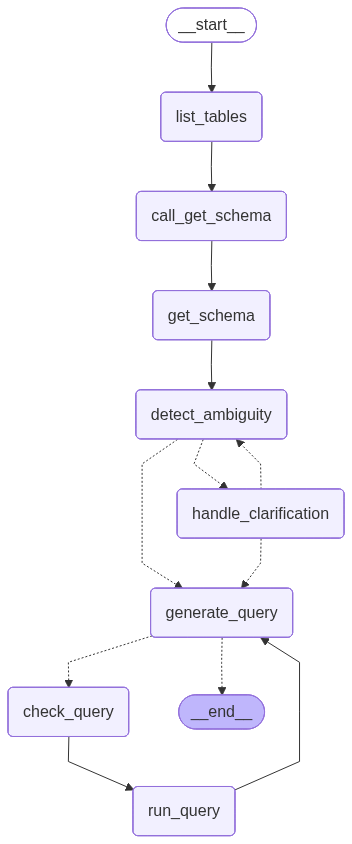

In [10]:
display(Image(agent.get_graph().draw_mermaid_png()))

## Test

In [11]:
config = {"configurable": {"thread_id": "test-3"}}

# 모호한 질문 테스트
test_question = "상반기에 가장 높은 금액의 거래는?"

for step in agent.stream(
    {
        "messages": [{"role": "user", "content": test_question}],
        "original_question": test_question
    },
    config,
    stream_mode="values",
):
    if "messages" in step:
        step["messages"][-1].pretty_print()

# 모든 Interrupt 처리 (여러 번의 명확화 질문 대응)
while True:
    state = agent.get_state(config)
    if not state.next:  # 더 이상 interrupt 없으면 종료
        break
    
    interrupt_value = state.tasks[0].interrupts[0].value
    print(f"\n--- CLARIFICATION NEEDED ---")
    print(f"Question: {interrupt_value['question']}")
    print(f"Choices: {interrupt_value['choices']}")
    
    # 첫 번째 선택지 자동 선택 (테스트용)
    user_choice = interrupt_value['choices'][0]
    print(f"User selected: {user_choice}\n")
    
    for step in agent.stream(
        Command(resume=user_choice),
        config,
        stream_mode="values",
    ):
        if "messages" in step:
            step["messages"][-1].pretty_print()

print("\n--- DONE ---")

================================ Human Message =================================

상반기에 가장 높은 금액의 거래는?
================================== Ai Message ==================================

Available tables: cards, customers, merchant_category, transactions
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_nCaJABUST36rvSs6Y0fQ7jxo)
 Call ID: call_nCaJABUST36rvSs6Y0fQ7jxo
  Args:
    table_names: transactions
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE transactions (
	id BIGINT, 
	date TEXT, 
	client_id BIGINT, 
	card_id BIGINT, 
	amount_usd FLOAT, 
	use_chip TEXT, 
	merchant_id BIGINT, 
	merchant_city TEXT, 
	merchant_state TEXT, 
	zip FLOAT, 
	mcc BIGINT, 
	errors TEXT
)

/*
3 rows from transactions table:
id	date	client_id	card_id	amount_usd	use_chip	merchant_id	merchant_city	merchant_state	zip	mcc	errors
7475327	2010-01-01 00:01:00	1556	2972	-77.0	Swipe 